In [1]:
import torch
import random
import matplotlib.pyplot as plt
from dataset_util.dataset import BinsceneA
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


BATCH_SIZE_TRAIN = 48
BATCH_SIZE_EVAL = 32
# create an instance of the BinsceneA dataset
binscene_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='full', premultiply_alpha=True)


# display some information on the dataset
print(f'The dataset contains {len(binscene_dataset)} samples.')
print(f'It contains objects from the following {len(binscene_dataset.class_labels)} classes:')
print(binscene_dataset.class_labels, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(binscene_dataset))
# 
img_tensor, object_visibility_vector = binscene_dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(binscene_dataset, batch_size=BATCH_SIZE_TRAIN,
                                          shuffle=True, num_workers=2)
print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of an object visibility vector is:', object_visibility_vector.shape)

The dataset contains 200000 samples.
It contains objects from the following 17 classes:
['cracker_box' 'sugar_box' 'mustard_bottle' 'potted_meat_can' 'banana'
 'bleach_cleanser' 'mug' 'sponge' 'spatula' 'power_drill' 'wood_block'
 'extra_large_clamp' 'softball' 'golf_ball' 'dice' 'toy_airplane'
 'red_box'] 

The shape of an image tensor is: torch.Size([3, 360, 640])
The shape of an object visibility vector is: torch.Size([17])


The shape of the image tensor is: torch.Size([3, 256, 384]) tensor(0.) tensor(0.9961)
The shape of the object visibility vector is: torch.Size([17])


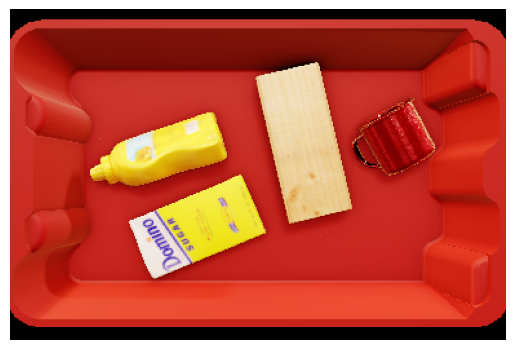

Visible objects are mug, mustard_bottle, red_box, sugar_box and wood_block.


In [3]:
import torchvision
# we don't need this module to warn us about all kinds of stuff
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import Resize, CenterCrop, Compose, Normalize

# transform is applied to the images, target transform is applied to the visibility vectors
# transformS is applied to a tuple of (image, visibility vector)
# These functions can be defined and chained as desired, but they expect torch tensors as inputs

# in this case we only transform the images by resizing them
# define the transform, this is just a function which takes and returns a tensor
resize_transform = Resize(size=(90, 160), antialias=True)
crop_transform = CenterCrop((256,384)) #Lambda(lambda t: t[...,14:90-14,32:160-32])
norm_transform = Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
image_transform2 = Compose([norm_transform,crop_transform])
image_transform = Compose([resize_transform, crop_transform])
# initialize a dataset which applies the transform to each sample image
transformed_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='val', premultiply_alpha=True, 
                                transform=crop_transform)
trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=BATCH_SIZE_TRAIN,
                                          shuffle=True, num_workers=12,pin_memory=True)

transformed_dataset_eval = BinsceneA(root='/data/BinsceneA_16_objects', split='val', premultiply_alpha=True, 
                                transform=crop_transform)
evalloader = torch.utils.data.DataLoader(transformed_dataset_eval, batch_size=BATCH_SIZE_EVAL,
                                          shuffle=True, num_workers=12,pin_memory=True)
# get a sample and print the shapes
sample_idx = random.randrange(len(transformed_dataset))
img_tensor_new, object_visibility_vector = transformed_dataset.__getitem__(sample_idx)
print('The shape of the image tensor is:', img_tensor_new.shape, img_tensor.min(), img_tensor.max())
print('The shape of the object visibility vector is:', object_visibility_vector.shape)
# visualize it
fig, ax = plt.subplots()
ax, image_description = transformed_dataset.show(img_tensor_new, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

In [4]:
from ldm_autoencoder import load_autoencoder

ldm_autoencoder_path = '/data/ldm_autoencoder_data/'

kl_f4_dict = {'checkpoint': 'autoencoder_kl_64x64x3.pth', 'config': 'autoencoder_kl_64x64x3.yaml'} # PSNR 27.53
kl_f8_dict = {'checkpoint': 'autoencoder_kl_32x32x4.pth', 'config': 'autoencoder_kl_32x32x4.yaml'} # PSNR 24.19
kl_f16_dict = {'checkpoint': 'autoencoder_kl_16x16x16.pth', 'config': 'autoencoder_kl_16x16x16.yaml'} # PSNR 24.08
kl_f32_dict = {'checkpoint': 'autoencoder_kl_8x8x64.pth', 'config': 'autoencoder_kl_8x8x64.yaml'} # PSNR 22.27

model = load_autoencoder(kl_f16_dict, ldm_autoencoder_path).to(device)
model.eval()

Restored from /data/ldm_autoencoder_data/pytorch_checkpoints/autoencoder_kl_16x16x16.pth


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [5]:
from torch.nn.functional import mse_loss as mse
def psnr_rate(input, target):
    return 10.0 * torch.log10(1 / mse(input, target, reduction='mean'))

In [6]:
@torch.no_grad()
def evaluate_autoenc(net, dataloader, device):
    BATCH_SIZE = 12
    net.eval()
    num_val_batches = len(dataloader)
    psnr_acc = []

    
    progress_bar = tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=True, position=0)
    for batch in progress_bar:
        progress_bar.set_postfix({'Total Batches': len(dataloader), 'Current PSNR': np.mean(psnr_acc)}, refresh=True)
        image, mask_true = batch[0], batch[1]

            # move images and labels to correct device and type
        image = image.to(dtype=torch.float32, memory_format=torch.channels_last).to(device)
        
        mask_pred, _ = net(image)
        psnr = psnr_rate(mask_pred, image)
        psnr_acc.append(psnr.item())
        
        
        


    net.train()
    return np.mean(psnr_acc)

In [7]:
def train_model_autoenc(
        model,
        device,
        epochs: int = 0,
        learning_rate: float = 1e-4,
        val_percent: float = 0.1,
        img_scale: float = 0.5,
        weight_decay: float = 1e-8,
        gradient_clipping: float = 1.0,
):
    
    min_loss = 1e25
    val_loss = -1e25
    kl_cancer_counter = 0
    progress_bar = tqdm(range(epochs), total=epochs, position=0, leave=True)
    for epoch in progress_bar:
        mean_epoch_loss = []
        model.train()
        running_loss = 0.0
        
        for i, data in enumerate(trainloader):
            image, mask_true = [t.to(device) for t in data]
            progress_bar.set_postfix({f'T of {[len(trainloader)]}' : i+1, 'Best loss': val_loss}, refresh=True)
            optimizer.zero_grad()
                # move images and labels to correct device and type
            #image = image.to(dtype=torch.float32, memory_format=torch.channels_last)

            mask_pred, latent = model(image)#.to(device)
            #if kl_cancer_counter <= 36667:
                #loss = criterion(mask_pred, image)
                #kl_cancer_counter+=1
            #else:
                #loss = criterion(mask_pred, image) + 1e-8 * latent.kl().mean() #normal_kl(batch_mean,torch.log(batch_var),0,0).mean()
            loss = criterion(mask_pred, image) + 1e-8 * latent.kl().mean() #normal_kl(batch_mean,torch.log(batch_var),0,0).mean()
            mean_epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            
            
            running_loss += loss.item()
        loss_mean = np.mean(mean_epoch_loss)
        # scheduler on loss_mean with patience 10 with more aggressive learning rate
        
        val_loss_psnr = evaluate_autoenc(model, evalloader, device=device)        
        scheduler.step(val_loss_psnr)
        if val_loss_psnr > val_loss:
            val_loss = val_loss_psnr
            #torch.save(model, 'autoencoder_binscene_pretrained_finetuned.pt')
        if epoch%1==0:
            print('---')
            print(f"Epoch: {epoch} | Train Loss: {loss_metrainan} | Best Loss: {min_loss} |")
            print(f"| Val Loss: {val_loss} |")
# validation loss for scheduler and model saving
# balance criterion and kl loss to find kl_loss weight
# track on validation set batch_mean.mean() and batch_var.mean() and val loss

In [8]:
#train_model_autoenc(model, device, learning_rate = learning_rate) 

In [9]:
#autoencoder = torch.load('autoencoder_binscene.pt')
#autoencoder.to(device)
#autoencoder.requires_grad_(requires_grad=False)
finetuned_model = torch.load('autoencoder_binscene_pretrained_finetuned.pt')
dataiter = iter(trainloader)
i, data = next(dataiter)
print(model)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [13]:
def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)

In [14]:
def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table)#.unsqueeze(0)

In [15]:
# ResBlock für DiffusionUnet
class ResBlock(nn.Module):
    def __init__(self, in_channels, emb_dim, out_channels=None, dropout = 0.0):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
       
        self.out_channels = out_channels
        # in-layer für z (zusätzlich nonlinearity von oben in forward benutzen)
        self.Vorverarbeitung_latent = nn.Sequential(
            Normalize(in_channels),
            torch.nn.SiLU(),
            torch.nn.Conv2d(in_channels,out_channels, kernel_size=3, stride=1, padding=1)
        )
        
        # nonlinearity wird vorher auf emb angewandt, danach das hier im forward
        self.emb_proj = nn.Sequential(nn.SiLU(),
                nn.Linear(emb_dim, out_channels))
        
        #Aufrufbarer Skip(z)
        if self.in_channels != self.out_channels:
            self.skip = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=1)
        else:
            self.skip = nn.Identity()
        
        #Outlayer vor dem Skip Block
        self.Outlayer = nn.Sequential(
            Normalize(out_channels),
            torch.nn.SiLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
        )
        
        
    def forward(self, inputs):
        zs, embs = inputs
        #Verarbeitung vom Latent
        h = zs
        
        h = self.Vorverarbeitung_latent(h)
        
        
        # Verarbeitung vom Embedding + hinzufügen zum Latent
        h = h + self.emb_proj(embs)[:,:,None,None] #aus NxC wird NxCx1x1
        
        #Outlayer von verarbeitetem z und inkludiertem embedding
        h = self.Outlayer(h)
        
        return self.skip(zs) + h
        

In [16]:
import math
class QKVAttention(nn.Module):
    """
    A module which performs QKV attention and splits in a different order.
    """

    def __init__(self):
        super().__init__()

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x C x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % 3 == 0
        ch = width // 3
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs, ch, length),
            (k * scale).view(bs, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(bs, ch, length))
        return a.reshape(bs, -1, length)

class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(self,channels):
        super().__init__()
        self.channels = channels
        self.norm = Normalize(channels) 
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.attention = QKVAttention()
        self.proj_out = torch.nn.Conv1d(channels, channels, 1)

    def forward(self, x):
        #x, emb = x? gebraucht?
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)

In [17]:
class DiffusionUNet(nn.Module):
    def __init__(self, n_channels=1, channels=[64,128,256,512,1024],t_max=1000, d_hid=100, n_classes = 17,dropout=0.1):
        super(DiffusionUNet, self).__init__()
        self.pos_enc = nn.parameter.Parameter(get_sinusoid_encoding_table(t_max, d_hid), requires_grad=False)
        
        self.first_layer = nn.Conv2d(16, channels[0], kernel_size=1, stride=1)
        
        self.time_emb_processed = nn.Sequential(
            torch.nn.Linear(d_hid, 4*d_hid, bias=False),
            torch.nn.SiLU(),
            torch.nn.Linear(4*d_hid, 4*d_hid, bias=False)
        ) 
        self.class_emb_processed = nn.Sequential(
            torch.nn.Linear(n_classes, 4*d_hid, bias=False),
            torch.nn.SiLU(),
            torch.nn.Linear(4*d_hid, 4*d_hid, bias=False)
        )
        
        
        self.downblocks_without_avgpool1 = make_resblocks(channels[0],channels[1],4*d_hid,dropout=dropout,num_resblocks=2)
        
        self.downblocks_without_avgpool2 = make_resblocks(channels[1],channels[2],4*d_hid,dropout=dropout,num_resblocks=2)

        self.downblocks_without_avgpool3 = make_resblocks(channels[2],channels[3],4*d_hid,dropout=dropout,num_resblocks=2)

        self.downblocks_without_avgpool4 = make_resblocks(channels[3],channels[4],4*d_hid,dropout=dropout,num_resblocks=2)

        
        self.downsample = nn.AvgPool2d(kernel_size =2, stride=2)
        self.final_downsample = nn.AvgPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
        
        self.middle_blocks = make_middle_blocks(channels[4], 4*d_hid, dropout=dropout, num_middle_blocks=1)
        
        self.out_blocks5 = make_outputblocks(2*channels[4],channels[4],4*d_hid,dropout=dropout,num_resblocks=1)
        self.out_blocks4 = make_outputblocks(2*channels[4],channels[3],4*d_hid,dropout=dropout,num_resblocks=1)
        self.out_blocks3 = make_outputblocks(2*channels[3],channels[2],4*d_hid,dropout=dropout,num_resblocks=1)
        self.out_blocks2 = make_outputblocks(2*channels[2],channels[1],4*d_hid,dropout=dropout,num_resblocks=1)
        self.out_blocks1 = make_outputblocks(2*channels[1],channels[0],4*d_hid,dropout=dropout,num_resblocks=1)
        
        self.up4 = nn.Conv2d(channels[4], channels[4], kernel_size=1, stride=1, padding=0)
        self.up3 = nn.Conv2d(channels[3], channels[3], kernel_size=1, stride=1, padding=0)
        self.up2 = nn.Conv2d(channels[2], channels[2], kernel_size=1, stride=1, padding=0)
        self.up1 = nn.Conv2d(channels[1], channels[1], kernel_size=1, stride=1, padding=0)
        
        self.final_layer = nn.Sequential(Normalize(channels[0]),
                                         nn.SiLU(),
                                         nn.Conv2d(channels[0], 16, kernel_size=1, stride=1))
        
        #self.upsample = nn.Sequential(F.interpolate(scale_factor=2),nn.Conv2d(kernel_size=3, stride=1, padding=1))
        
            
    def forward(self, inputs):
        z , t , y = inputs
        enc = self.pos_enc[t]
        t = self.time_emb_processed(enc)
        if y is not None:
            y = y.float()
            y = self.class_emb_processed(y)
            emb = t + y
        else:
            emb = t
        list_zs = []
        z = self.first_layer(z)#torch.Size([6, 128, 16, 24])
        #input blocks
        #print(z.shape)
        for resblock in self.downblocks_without_avgpool1:
            z = resblock((z,emb))
        list_zs.append(z)
        z = self.downsample(z)#torch.Size([6, 256, 8, 12])
        #print(z.shape)
        for resblock in self.downblocks_without_avgpool2:
            z = resblock((z,emb))
        list_zs.append(z)
        z = self.downsample(z)#torch.Size([6, 512, 4, 6])
        #print(z.shape)
        for resblock in self.downblocks_without_avgpool3:
            z = resblock((z,emb))
        list_zs.append(z)
        z = self.downsample(z)#torch.Size([6, 1024, 2, 3])
        #print(z.shape)
        for resblock in self.downblocks_without_avgpool4:
            z = resblock((z,emb))
        list_zs.append(z)
        z = self.final_downsample(z)#torch.Size([6, 2048, 1, 2])
        #print(z.shape)
        list_zs.append(z)
        
        
        for middleblock in self.middle_blocks:
            z = middleblock((z,emb))#torch.Size([6, 2048, 1, 2])
        #print(z.shape)
        
        
        z = concat_zs(z, list_zs.pop())#torch.Size([6, 4096, 1, 2])
        #print(z.shape)
        for outblock in self.out_blocks5:
            z = outblock((z,emb))
        z = F.interpolate(z, size=(2, 3))#torch.Size([6, 2048, 2, 3])
        #print(z.shape)
        z = self.up4(z)#torch.Size([6, 2048, 2, 3])
        #print(z.shape)
        
        z = concat_zs(z, list_zs.pop())
        for outblock in self.out_blocks4:
            z = outblock((z,emb))
        z = F.interpolate(z, scale_factor = 2)
        z = self.up3(z)#torch.Size([6, 1024, 4, 6])
        #print(z.shape)
        
        z = concat_zs(z, list_zs.pop())
        for outblock in self.out_blocks3:
            z = outblock((z,emb))
        z = F.interpolate(z, scale_factor = 2)
        z = self.up2(z)#torch.Size([6, 512, 8, 12])
        #print(z.shape)
        
        z = concat_zs(z, list_zs.pop())
        for outblock in self.out_blocks2:
            z = outblock((z,emb))
        z = F.interpolate(z, scale_factor = 2)
        z = self.up1(z)#torch.Size([6, 256, 16, 24])
        #rint(z.shape)
        
        z = concat_zs(z, list_zs.pop())
        for outblock in self.out_blocks1:
            z = outblock((z,emb))
        z = self.final_layer(z)#torch.Size([6, 16, 16, 24])
        #print(z.shape)
        
        
        
        return z
        #middle blocks
        
        
        
        #output blocks
        
def make_middle_blocks(channels, embed_dim, dropout, num_middle_blocks):
    layers = []
    for _ in range(num_middle_blocks):
        layers.append(torch.nn.Sequential(ResBlock(channels, embed_dim, channels, dropout), AttentionBlock(channels)))
        layers.append(torch.nn.Sequential(ResBlock(channels, embed_dim, channels, dropout)))
    return torch.nn.ModuleList(layers)
        
def make_resblocks(in_channels, out_channels, embed_dim, dropout, num_resblocks):
    # pro resblock
    layers = [torch.nn.Sequential(ResBlock(in_channels, embed_dim, out_channels, dropout),
             AttentionBlock(out_channels))]
    for i in range(num_resblocks-1):
        layers.append(torch.nn.Sequential(ResBlock(out_channels, embed_dim, out_channels, dropout),
             AttentionBlock(out_channels)))
    return torch.nn.ModuleList(layers)


def make_outputblocks(in_channels,out_channels,embed_dim,dropout, num_resblocks):
    layers = [nn.Sequential(
            ResBlock(in_channels, embed_dim, out_channels, dropout),
            AttentionBlock(out_channels))]
    for _ in range(num_resblocks-1):
        layers.append(nn.Sequential(ResBlock(in_channels, embed_dim, out_channels, dropout),
            AttentionBlock(out_channels)))
    return nn.ModuleList(layers)
    
    
def concat_zs(x1,x2):
    # input is CHW
    #Diese Zeilen berechnen die Größenunterschiede
    #in den Höhen- und Breitenrichtungen zwischen x2 und dem upgesampleten x1.
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]
        
    #Diese Zeile fügt x1 an den Rändern Polster hinzu, 
    #sodass es die gleiche räumliche Größe wie x2 hat. Das 
    #Padding sorgt dafür, dass die beiden Feature-Maps aneinander angehängt werden können.

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
    x = torch.cat([x2, x1], dim=1)
    return x

In [18]:
def mache_noise_direkt_random(batch_images, total_steps=1000, device=device):
    # Verschieben Sie den Batch auf die GPU
    batch_images = batch_images.to(device)
    
    # Annahme: batch_images hat die Form [batch_size, channels, height, width]
    batch_size = batch_images.size(0)
    
    alpha_quer_list = berechne_alpha_quer_x_forward_steps(total_steps)
    alpha_quer = torch.tensor(alpha_quer_list, device=device)

    noisy_batch = []
    epsilons = []
    anzahl_steps_array = np.empty(batch_size)
    # for loop vernichten
    for i in range(batch_size):
        anzahl_steps = np.random.randint(total_steps)
        anzahl_steps_array[i] = anzahl_steps
        
        image = batch_images[i]
        noisy_image, eps = x_forward_steps(image.unsqueeze(0).to(device), alpha_quer[anzahl_steps-1])  # Verschieben auf die GPU
        
        noisy_batch.append(noisy_image)
        epsilons.append(eps)
    
    noisy_batch_tensor = torch.cat(noisy_batch, dim=0).to(device)  # Verschieben auf die GPU
    epsilons_tensor = torch.cat(epsilons, dim=0).to(device)  # Verschieben auf die GPU
    
    return noisy_batch_tensor, epsilons_tensor, anzahl_steps_array


In [19]:
def berechne_alpha_quer_x_forward_steps(anzahl_steps):
    scheduler = create_linear_schedule(anzahl_steps, 0.0001, 0.02)
    alphas = 1 - np.array(scheduler)
    alphas_quer = []
    for i in range(len(alphas)):
        alphas_quer.append(np.prod(alphas[:i + 1]))
    return alphas_quer

In [20]:
def x_forward_steps(curr_image, alpha_quer):
    alpha_quer = torch.tensor(alpha_quer)
    alpha_quer = alpha_quer.clone().detach().float().to(device)  # 'device' is your CUDA device
    std = torch.sqrt(1 - alpha_quer)
    mean = torch.sqrt(alpha_quer) * curr_image
    new_image, eps = add_gaussian_noise(curr_image,mean=mean,std=std)
    return new_image, eps

In [21]:
# Function to add Gaussian noise to an image tensor
def add_gaussian_noise(image, mean=0., std=1.):
    eps = torch.empty_like(image).normal_(mean=0,std=1)
    noise = eps * std + mean
    # beta*eps + sqrt(1-beta)*image+std # (1-beta).sqrt()*image + beta*eps
    # Clip the values to be between 0 and 1
    # noisy_image = normalize_image(noisy_image)
    return noise, eps

In [22]:
def create_linear_schedule(steps, start, end):
    step_size = (end - start) / (steps - 1)  
    linear_schedule = []
    for i in range(steps):
        linear_schedule.append(start + i * step_size)
    return linear_schedule

In [23]:
diff_unet = DiffusionUNet().to(device)

In [24]:
def mache_noise_direkt(image, anzahl_steps, total_steps=1000):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    noisy_image_tensor = image
    
    alpha_quer = berechne_alpha_quer_x_forward_steps(total_steps)
    
    noisy_image_tensor, eps = x_forward_steps(noisy_image_tensor, alpha_quer[anzahl_steps-1])
    noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
    
    return noisy_image_tensor, eps

In [26]:
dataiter = iter(trainloader)
my_image, my_classes = next(dataiter)
my_image = my_image.to(device)
print(my_image.shape)
my_image = my_image[0:1]
#print(my_image.shape)
my_classes = my_classes.to(device)
learning_rate = 1e-4
vector = torch.full((1,), 500)
std = my_image.std()


torch.Size([48, 3, 256, 384])


In [27]:
def train_diffusion_model(
        diffusion_model,
        autoenc_model,
        device,
        epochs: int = 5000,
        learning_rate: float = 2e-4,
        val_percent: float = 0.1,
        img_scale: float = 0.5,
        weight_decay: float = 1e-8,
        gradient_clipping: float = 50.0,
):
    print(std)
    min_loss = 1e25
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(diff_unet.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.1, patience=2, verbose=True)
    progress_bar = tqdm(range(epochs), total=epochs, position=0, leave=True)
    for epoch in progress_bar:
        mean_epoch_loss = []
        diffusion_model.train()
        running_loss, batch_loss = 0.0, 1e25
        for i, data in enumerate(trainloader):
            image, mask_true = [t.to(device) for t in data]
            progress_bar.set_postfix({f'T of {[len(trainloader)]}' : i+1, "BatchLoss": batch_loss, 'Best loss': min_loss, "Current Patience" : scheduler.num_bad_epochs, "Learning Rate" : optimizer.param_groups[0]['lr']}, refresh=True)
            optimizer.zero_grad()
                # move images and labels to correct device and type
            with torch.no_grad():
                enc_dist = autoenc_model.encode(image)
                enc_latent = enc_dist.sample()
                enc_latent = enc_latent / std
                #print(enc_latent.shape) # torch.Size([48, 16, 16, 24])
                noisy_latent, eps, anzahl_schritte = mache_noise_direkt_random(enc_latent)
                #print(eps.shape, noisy_latent.shape) # torch.Size([48, 16, 16, 24]) torch.Size([48, 16, 16, 24])
                mask_true = mask_true.float()
                #print(enc_latent.min(), enc_latent.max()) # -18.4872 16.5605
                #print(eps.min(), eps.max()) # -4.7765 4.5985
                #print(noisy_latent.min(), noisy_latent.max()) # -18.2475 16.4791
                eingabe = noisy_latent, anzahl_schritte, mask_true
            eps_pred = diffusion_model(eingabe)
            #print(eps_pred.shape) # torch.Size([48, 16, 16, 24])
            #print(eps_pred.min(),eps_pred.max()) #-2.1551 1.7823
            loss = criterion(eps, eps_pred)
            batch_loss = loss.item()
            mean_epoch_loss.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(diffusion_model.parameters(), max_norm=gradient_clipping)
            optimizer.step()
            
            
            running_loss += loss.item()
        
        loss_mean = np.mean(mean_epoch_loss)
        # scheduler on loss_mean with patience 10 with more aggressive learning rate
        scheduler.step(loss_mean)
        if loss_mean < min_loss:
            min_loss = loss_mean
            #torch.save(diffusion_model, 'binscenes_ldm_with_classes_small_sample_std.pt')
        if epoch%3==0:
            print('---')
            print(f"Epoch: {epoch} | Train Loss: {loss_mean} | Best Loss: {min_loss}")

In [28]:
#train_diffusion_model(diff_unet, model, device)

tensor(0.3302, device='cuda:0')


  0%|          | 0/5000 [00:00<?, ?it/s]

/tmp/ipykernel_1612/3828524275.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_quer = torch.tensor(alpha_quer)
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send

KeyboardInterrupt: 

In [44]:
def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=1, num_channels=in_channels, eps=1e-6, affine=True)

In [45]:
def mache_noise_direkt(image, anzahl_steps, total_steps=1000):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    noisy_image_tensor = image
    
    alpha_quer = berechne_alpha_quer_x_forward_steps(total_steps)
    
    noisy_image_tensor, eps = x_forward_steps(noisy_image_tensor, alpha_quer[anzahl_steps-1])
    noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
    
    return noisy_image_tensor, eps

In [71]:
diff_unet_trained = torch.load('binscenes_ldm_with_classes_small.pt').to(device)
diff_unet_trained.eval()

DiffusionUNet(
  (first_layer): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
  (time_emb_processed): Sequential(
    (0): Linear(in_features=100, out_features=400, bias=False)
    (1): SiLU()
    (2): Linear(in_features=400, out_features=400, bias=False)
  )
  (class_emb_processed): Sequential(
    (0): Linear(in_features=17, out_features=400, bias=False)
    (1): SiLU()
    (2): Linear(in_features=400, out_features=400, bias=False)
  )
  (downblocks_without_avgpool1): ModuleList(
    (0): Sequential(
      (0): ResBlock(
        (Vorverarbeitung_latent): Sequential(
          (0): GroupNorm(32, 64, eps=1e-06, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_proj): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=128, bias=True)
        )
        (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (Outlayer): Sequential(
          (0): Grou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


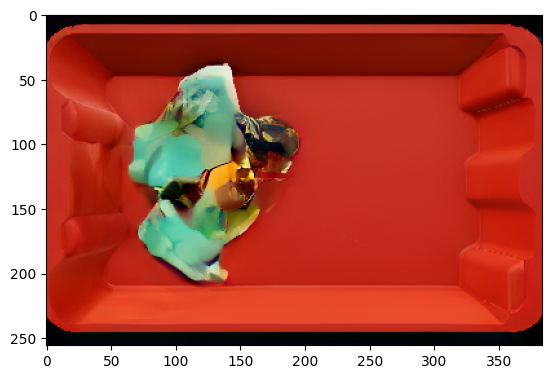

In [118]:
from IPython.display import display, clear_output

my_images_for_animation = []
dataiter = iter(trainloader)
i, data = next(dataiter)
new_std = 0.3339
betas = create_linear_schedule(1000, 0.0001, 0.02)
alphas = 1 - np.array(betas)
alphas_quer = []
for k in range(len(alphas)):
    alphas_quer.append(np.prod(alphas[:k + 1]))

#encoder    
with torch.no_grad():
  
    enc_dist = model.encode(i[0:1].to(device))
    print(i[0:1].shape)
    enc_latent = enc_dist.mode()
    print(enc_latent.shape)
    
    latent_noise, eps = mache_noise_direkt(enc_latent, 1000)
    print(latent_noise.shape)
    latent_noise = torch.randn_like(latent_noise)
    class_vec = torch.zeros_like(data[0:1])
    class_vec[0,-1] = 1
    #class_vec[0,-16] = 1
    class_vec[0,-2] = 1
    #class_vec[0,-4] = 1
    #class_vec[0,-13] = 1
    #class_vec = data[0:1]
    fig, ax = plt.subplots()
    latent_noise = latent_noise #/ new_std

    for j in reversed(range(999)):
        
        noise_pred = diff_unet_trained((latent_noise, torch.tensor([j]).to(device), class_vec.to(device)))
        if j > 1:
            z = torch.randn_like(latent_noise)
        else:
            z = torch.zeros_like(latent_noise)
        #ausführliche Definition von Sigma:   
        #img_noise = (1/np.sqrt(alphas[j+1])) * (img_noise - ((1- alphas[j+1])/(np.sqrt(1-alphas_quer[j+1]))) * img_pred) + np.sqrt((1-alphas_quer[j])/(1-alphas_quer[j+1]) *betas[j+1])*z
        #Sigma^2 = beta:
        # Alter Ansatz: DDPM
        latent_noise = (1/np.sqrt(alphas[j+1])) * (latent_noise - ((1- alphas[j+1])/(np.sqrt(1-alphas_quer[j+1]))) * noise_pred) + np.sqrt(betas[j+1])*z

        
        if j % 50 == 0:
            temp_img = model.decode(latent_noise)
            print(temp_img.shape)
            my_images_for_animation.append(temp_img)
            clear_output(wait=True)  # Löscht die vorherige Ausgabe
            
            plt.imshow(temp_img[0].cpu().detach().numpy().transpose((1,2,0)))
            plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

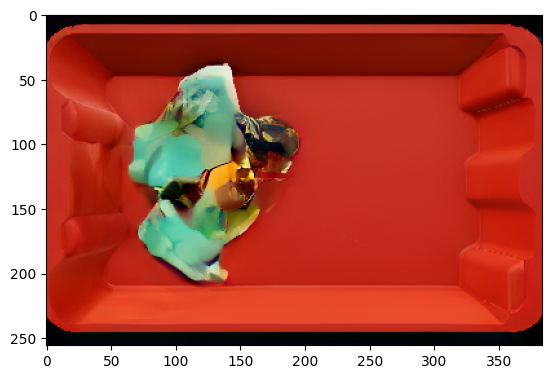

In [119]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

for m in range(10):
    my_images_for_animation.append(my_images_for_animation[-1])
# Ihr Array coole_generierte_bilder
# Beispiel: coole_generierte_bilder = [np.random.rand(100, 100) for _ in range(10)]

im = ax.imshow(my_images_for_animation[0].cpu().detach().numpy()[0].transpose((1,2,0)))

def update(num):
    im.set_array(my_images_for_animation[num].cpu().detach().numpy()[0].transpose((1,2,0)))
    return im,

ani = animation.FuncAnimation(fig, update, frames=range(len(my_images_for_animation)), blit=True)

ani.save('red_box_plane_diffusion.gif', writer='pillow')

In [79]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [83]:
print("AutoEncParam: " , count_parameters(model))

AutoEncParam:  69610963


In [84]:
print("UnetParam: " , count_parameters(diff_unet_trained))

UnetParam:  155722528
